In [1]:
from dataset import *

In [2]:
data_files = ['D:/senior/aiCourse/dataSource/comment_classification/output/train.json']
vocab_file = 'D:/senior/aiCourse/dataSource/comment_classification/output/vocab.txt'
label_file = 'D:/senior/aiCourse/dataSource/comment_classification/labels.txt'
enb_file = 'D:/senior/aiCourse/dataSource/comment_classification/embedding/embedding.txt'
batch_size = 128
reverse = False
split_word = True
max_len = 200

In [3]:
dataset1 = DataSet(  data_files,  vocab_file,   label_file,   batch_size, reverse=  reverse, split_word=  split_word, max_len=  max_len)

# vocab size:  50000
# vocab size:  20
# Start to preprocessing data...
# load data from D:/senior/aiCourse/dataSource/comment_classification/output/train.json ...
# Got 105000 data items with 820 batches


In [4]:
dataset1._raw_data[2][0]

[1,
 12,
 2331,
 351,
 290,
 239,
 290,
 6,
 946,
 1639,
 1977,
 794,
 917,
 10,
 5666,
 32,
 476,
 1343,
 278,
 1343,
 13,
 14,
 24,
 2898,
 1532,
 10723,
 10,
 31,
 1231,
 1532,
 31,
 5407,
 4035,
 21681,
 1328,
 2989,
 10,
 160,
 2459,
 405,
 211,
 12,
 26,
 715,
 3467,
 2191,
 145,
 254,
 14,
 1877,
 219,
 2191,
 2172,
 1228,
 3648,
 36,
 4883,
 9376,
 22,
 3,
 6,
 179,
 7,
 288,
 6,
 7,
 206,
 3293,
 14,
 332,
 190,
 3603,
 13,
 1328,
 2201,
 190,
 126,
 3,
 30,
 55,
 641,
 3583,
 55,
 10,
 453,
 1865,
 61,
 520,
 315,
 1865,
 210,
 4,
 1971,
 0,
 1971,
 579,
 807,
 256,
 413,
 23,
 122,
 265,
 179,
 293,
 12,
 24,
 13,
 616,
 711,
 264,
 2]

In [5]:
len(dataset1._raw_data[2][2].flatten().tolist())

80

In [6]:
emb_dict,emb_size = load_embed_file(enb_file)

In [7]:
def dig_lists(l):
    output = []
    for e in l:
        if isinstance(e, list):
            output += dig_lists(e)
        else:
            output.append(e)
    return(output)

In [8]:
dataset1._raw_data[2][0]

[1,
 12,
 2331,
 351,
 290,
 239,
 290,
 6,
 946,
 1639,
 1977,
 794,
 917,
 10,
 5666,
 32,
 476,
 1343,
 278,
 1343,
 13,
 14,
 24,
 2898,
 1532,
 10723,
 10,
 31,
 1231,
 1532,
 31,
 5407,
 4035,
 21681,
 1328,
 2989,
 10,
 160,
 2459,
 405,
 211,
 12,
 26,
 715,
 3467,
 2191,
 145,
 254,
 14,
 1877,
 219,
 2191,
 2172,
 1228,
 3648,
 36,
 4883,
 9376,
 22,
 3,
 6,
 179,
 7,
 288,
 6,
 7,
 206,
 3293,
 14,
 332,
 190,
 3603,
 13,
 1328,
 2201,
 190,
 126,
 3,
 30,
 55,
 641,
 3583,
 55,
 10,
 453,
 1865,
 61,
 520,
 315,
 1865,
 210,
 4,
 1971,
 0,
 1971,
 579,
 807,
 256,
 413,
 23,
 122,
 265,
 179,
 293,
 12,
 24,
 13,
 616,
 711,
 264,
 2]

In [9]:
def pad_sequences(comment_to_id,maxlen,padding,truncating):
    features = np.zeros((len(comment_to_id), maxlen), dtype=int)
    for i,comment in enumerate(comment_to_id):
        if len(comment) <= maxlen and padding == 'pre':
            features[i, -len(comment):] = np.array(comment)[:maxlen]
        if len(comment) <= maxlen and padding == 'post':
            features[i, :len(comment)] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'post':
            features[i, :] = np.array(comment)[:maxlen]
        if len(comment) > maxlen and truncating == 'pre':
            features[i, :] = np.array(comment)[len(comment)-maxlen:]           
    return features

def split_dataset(pad_comments,labels,split_frac):
    split_index = int(len(pad_comments)*split_frac)
    data_list = list(zip(pad_comments, labels))
    random.shuffle(data_list)
    pad_comments, labels = zip(*data_list)
    x_train, x_test = pad_comments[:split_index], pad_comments[split_index:]
    y_train, y_test = labels[:split_index], labels[split_index:]
    return x_train,y_train,x_test,y_test 

In [10]:
comment_to_id = [x[0] for x in dataset1._raw_data]
pad_comments = pad_sequences(comment_to_id,maxlen=200,padding='post',truncating='post')

In [11]:
y_test = [x[2].flatten().tolist() for x in dataset1._raw_data]

In [26]:
import random
x_train,y_train,x_test,y_test = split_dataset(pad_comments[:1000],y_test,0.8)

In [27]:
len(y_train)

800

# Model

In [28]:
from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.callbacks import Callback
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.preprocessing import text, sequence
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def get_model():
    embed_size=128
    sequence_input = Input(shape=(200, ))
    x = Embedding(90000, embed_size, trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.2))(x)
    x = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool]) 
    # x = Dense(128, activation='relu')(x)
    # x = Dropout(0.1)(x)
    preds = Dense(80, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])
    return model

In [29]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test) 

In [30]:
max_comment_length = 200
embedding_vecor_length = 300

In [31]:
model = get_model()

In [32]:
print(model.summary())
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=2,verbose=1, batch_size=40)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 128)     11520000    input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 128)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 200, 256)     197376      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_4 (

In [33]:
import matplotlib.pyplot as plt

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


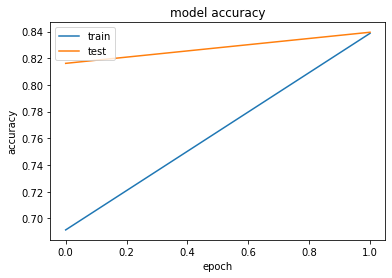

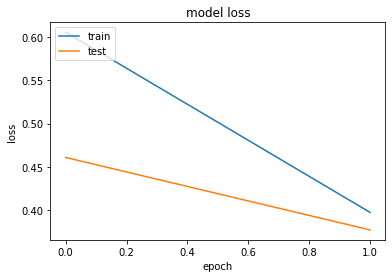

0.0


In [34]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(x_train)
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
print(accuracy(preds,y_train))

In [35]:
preds

array([[0.19935302, 0.00488335, 0.04022561, ..., 0.00740659, 0.01414016,
        0.6266717 ],
       [0.20634392, 0.00519999, 0.04380498, ..., 0.00804847, 0.01533185,
        0.62488806],
       [0.26609212, 0.02823315, 0.14940813, ..., 0.03971523, 0.0666603 ,
        0.57183444],
       ...,
       [0.18833977, 0.00400389, 0.0399075 , ..., 0.00636886, 0.01272756,
        0.6255953 ],
       [0.20423026, 0.00524352, 0.04280753, ..., 0.00797087, 0.01504618,
        0.62575936],
       [0.2426761 , 0.00986089, 0.08027367, ..., 0.01698911, 0.03119271,
        0.60945594]], dtype=float32)

In [36]:
def convert_2_labels(answer):
    labels_input = []
    for item in answer:
        answer_temp = []
        for i in range(0,80,4):
            answer_temp.append(np.argmax(item[i:i+4]))
        labels_input.append(answer_temp)
    return labels_input



In [37]:
convert_2_labels(preds)

[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,